<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/stock_acq_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Data Acquisition**

In this notebook we will develop a method to acquire stock data from yahoo finance

## Install necessary Libraries

In [ ]:
!pip install yfinance

In [ ]:
!pip install pandas_ta

In [ ]:
!pip install alpha_vantage

## Base Library Import

In [4]:
import os
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import alpha_vantage
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

## **Data download pipeline**

Here we will define functions to download our data into simple OHLCV Pandas DataFrames. These functions are meant to work for 15min intervals, but can be modified to work on other intervals.

In [10]:
# ALpha Vantage API Key goes here
API_KEY = 'K1GZTUTQ65SVGLNU'

In [13]:
BASE_URL = 'https://www.alphavantage.co/query?'
FUNCTION = 'TIME_SERIES_INTRADAY_EXTENDED'

In [81]:
import csv
import requests

def get_stock_data(symbol,
                   tslice,
                   interval='15min',
                   adjusted='true'):

    # get url for Alpha Vantage API
    csv_url = (f'{BASE_URL}function={FUNCTION}' 
               + f'&symbol={symbol}'
               + f'&slice={tslice.strip()}'
               + f'&interval={interval}'
               + f'&apikey={API_KEY}')

    # query Alpha Vantage and get _csv.reader object
    with requests.Session() as s:
        download = s.get(csv_url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')

    # place _csv.read object into a DataFrame
    df = pd.DataFrame(list(cr))
    df.columns = df.iloc[0, :]
    df.drop(axis=0, index=0, inplace=True)
    df.index = df.time
    df.drop(axis=1, columns=['time'], inplace=True)
    df = df.astype(np.float64).sort_index()

    return df

In [85]:
import time

def get_multi_periods(symbol, interval='15min', adjusted='true'):
    ''' Obtains data for all periods in a given short term interval (15min) '''

    year = [2] # [1, 2]
    month = [1,2,3,4,5] # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    
    stock_dfs = []

    for y in year:
        for m in month:
            try:
                _df = get_stock_data(symbol, tslice=f'year{y}month{m}')
                stock_dfs.append(_df)
            except AttributeError as err:
                print(err)
                print('Error: ', f'year{y}month{m}')

            # pause exceution for API (5 calls per minute limit)
            # time.sleep(20)


    # get single stock DataFrame
    stock_df = pd.concat(stock_dfs, axis=0).sort_index()

    return stock_df

In [86]:
df = get_multi_periods(symbol='AAPL')

In [87]:
df

,open,high,low,close,volume
time,,,,,
2021-04-27 04:15:00,133.711879,133.820918,133.583014,133.583014,5725.0
2021-04-27 04:30:00,133.513626,133.612752,133.513626,133.592927,844.0
2021-04-27 04:45:00,133.612752,133.662316,133.612752,133.662316,1352.0
2021-04-27 05:00:00,133.662316,133.662316,133.662316,133.662316,1270.0
2021-04-27 05:15:00,133.682141,133.860569,133.682141,133.860569,7127.0
...,...,...,...,...,...
2021-09-23 19:00:00,146.022933,146.032877,145.963266,146.022933,4000.0
2021-09-23 19:15:00,146.003044,146.062710,146.003044,146.062710,6854.0
2021-09-23 19:30:00,146.052766,146.082599,146.032877,146.072654,11285.0


Save to a .csv for later usage

In [88]:
df.to_csv('aapl_15min_20210427_2021_0923.csv')

## Checkpoint

In [ ]:
# df = pd.read_csv('aapl_15min_20210824_2021_0922.csv', index_col=0)
# df

We can plot a candle stick chart if we want to, see [this](https://www.statology.org/matplotlib-python-candlestick-chart/)

Now we can close inspect and analye the training data. The first thing we will do is plot Simple Moving Averages (SMA) which that the unweighted mean of the previous M points

In [89]:
# compute simple moving averages
close_sma_10 = df['close'].rolling(10, min_periods=1).mean()# .name('close SMA 10')
close_sma_30 = df['close'].rolling(30, min_periods=1).mean()

# rename series
close_sma_10.name = 'close SMA 10'
close_sma_30.name = 'close SMA 30'

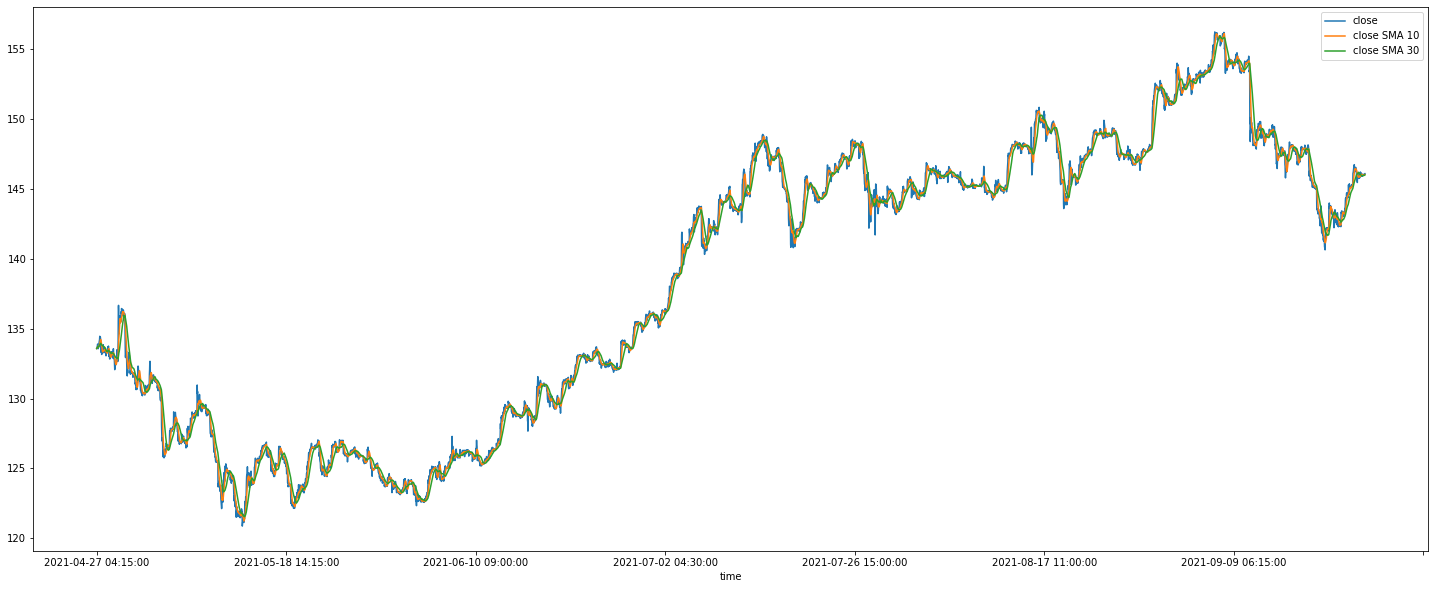

In [90]:
df['close'].plot(figsize=(25, 10))
close_sma_10.plot(figsize=(25, 10))
close_sma_30.plot(figsize=(25, 10))
plt.legend();

Now we will compute the Exponential Moving Average (EMA), the EMA gives more weight to more recent points and is useful to identify trends and filter out noise. Thee EMA formula has a smoothing factor $\alpha \in [0, 1]$ which allows for more or less smoothing. The smaller the $\alpha$, the more smoothing we get.

In [91]:
# compute Exponentially Weighted Mean
close_ema_01 = df['close'].ewm(alpha=0.1).mean()
close_ema_03 = df['close'].ewm(alpha=0.3).mean()
close_ema_05 = df['close'].ewm(alpha=0.5).mean()

# rename series
close_ema_01.name = 'close EMA 0.1'
close_ema_03.name = 'close EMA 0.3'
close_ema_05.name = 'close EMA 0.5'

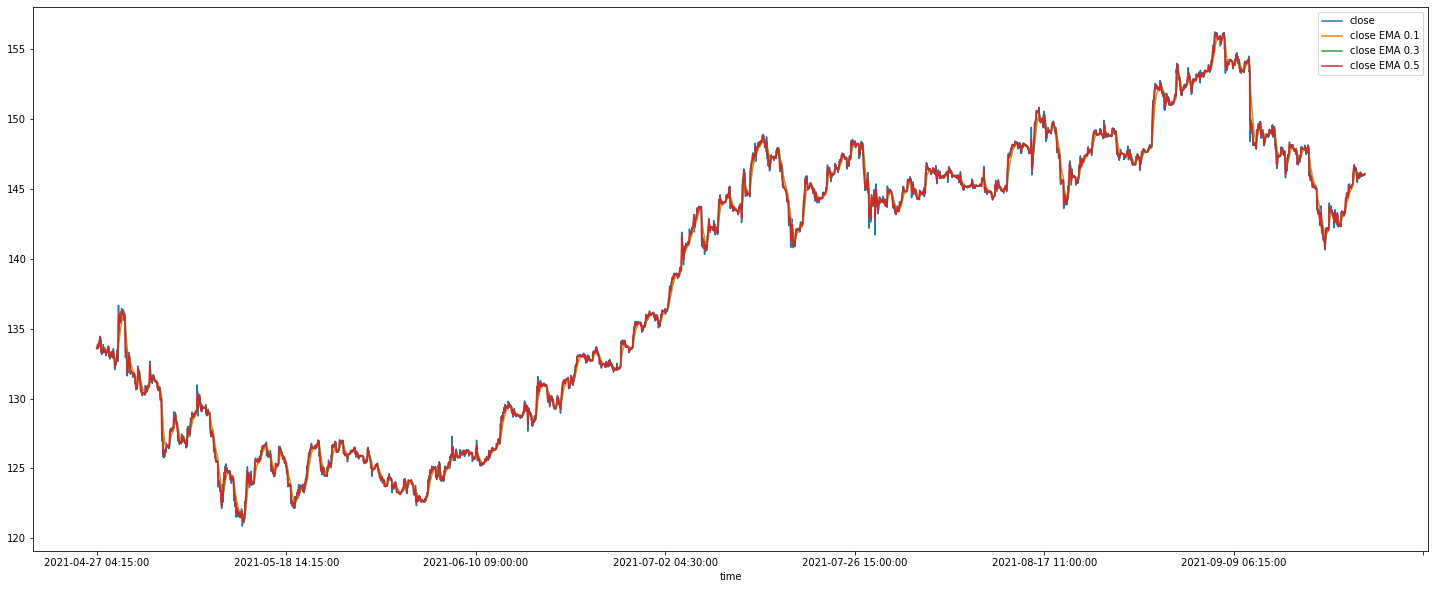

In [92]:
df['close'].plot(figsize=(25, 10))
close_ema_01.plot(figsize=(25, 10))
close_ema_03.plot(figsize=(25, 10))
close_ema_05.plot(figsize=(25, 10))
plt.legend();

We can see that chooseing an $\alpha$ value of $0.5$ gives a fairly good representation of the Time Series with a decent amount of noise removed

Now we will plot the Autocorrelation function ([ACF](https://en.wikipedia.org/wiki/Autocorrelation)]. The Autocorrelation is the correlation of a signal with a delayed copy of itself. The ACF can reveal which lags have significant correlations.

See [this](https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/) for autocorrelation VS partial autocorrelation

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

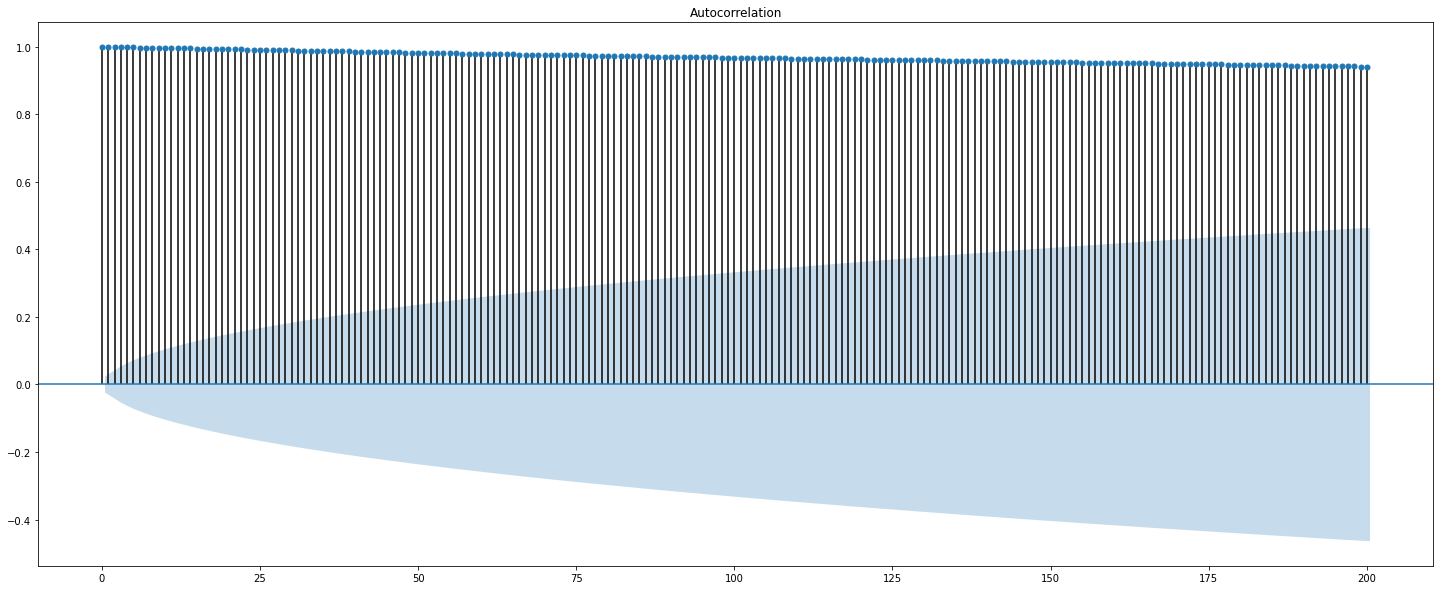

In [94]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_acf(df['close'], lags=200, ax=ax);

From this Autocorrelation plot, we can determine which lags have significant correlations. The lags above the shaded region are statistically significant, the default $\alpha$ value for significance is 0.05. We may be able to suggest that there are trends in the Time Series, since the autocorrelation lags taper off slowly as they increase in value. We can also confirm from the Autocorrelation plot that the stock data is highly non stationary.

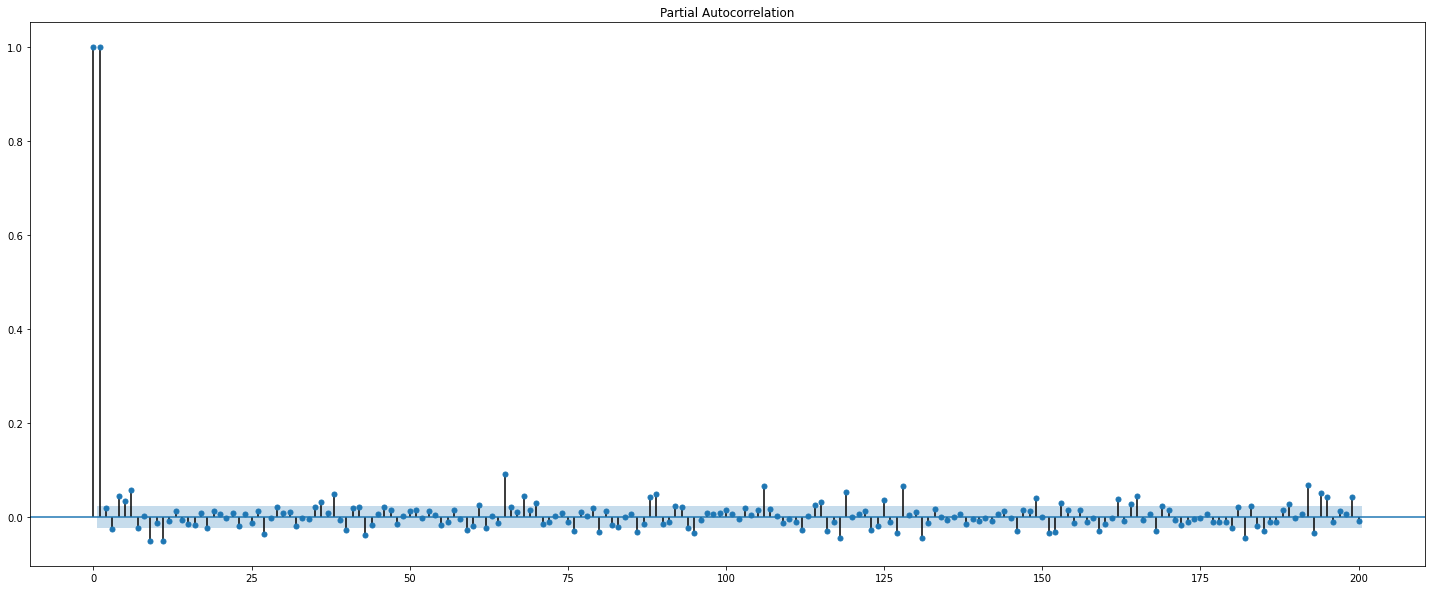

In [95]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_pacf(df['close'], lags=200, ax=ax);

For differences between Autocorrelation and Partial Autocoorelation see [this](https://emel333.medium.com/interpreting-autocorrelation-partial-autocorrelation-plots-for-time-series-analysis-23f87b102c64). The main difference is that Partial Autocorrelation shows the relationship between an observation and previous observations with the relationships of intervening observations removed. The two large postive autocorrelations suggests that we could use a 2nd order Auto Regressize (AR) model to model this stock data.

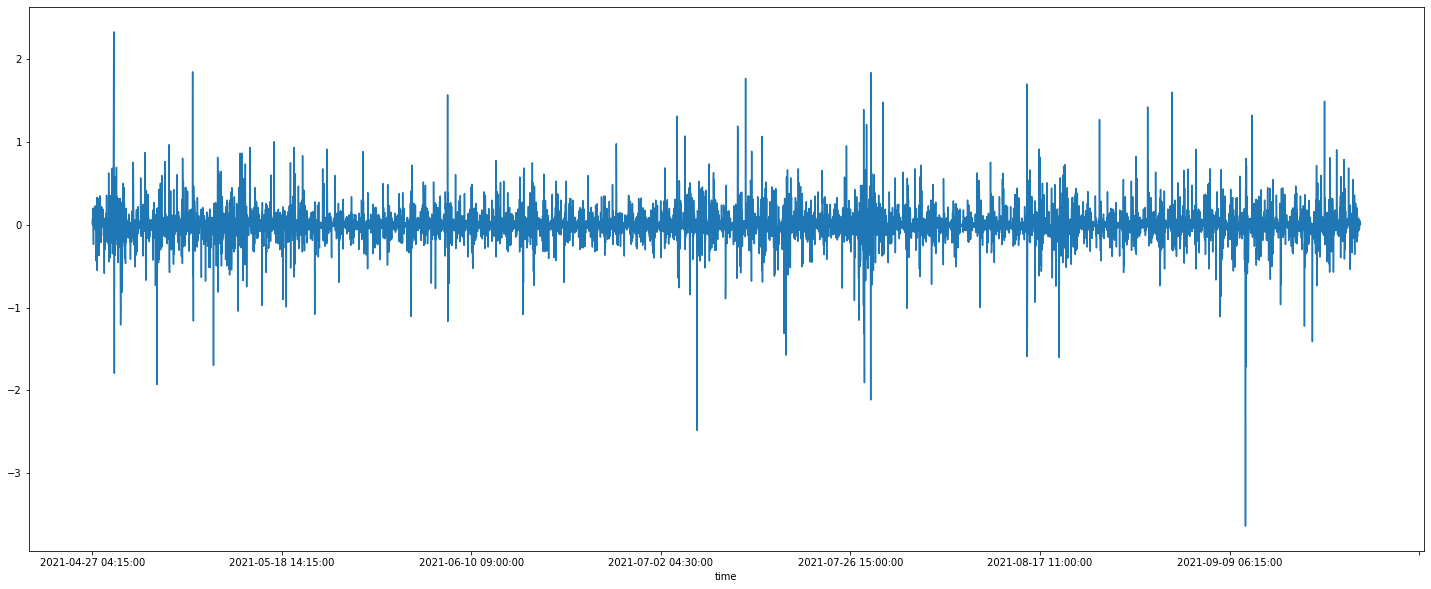

In [97]:
close_diff = df['close'].diff().sort_index() # ensure that the dates are ordered
close_diff.names = 'close diff'
close_diff.plot(figsize=(25, 10));

In [98]:
close_diff.describe()

count    6691.000000
mean        0.001868
std         0.236532
min        -3.638938
25%        -0.079555
50%         0.000000
75%         0.081402
max         2.329475
Name: close, dtype: float64

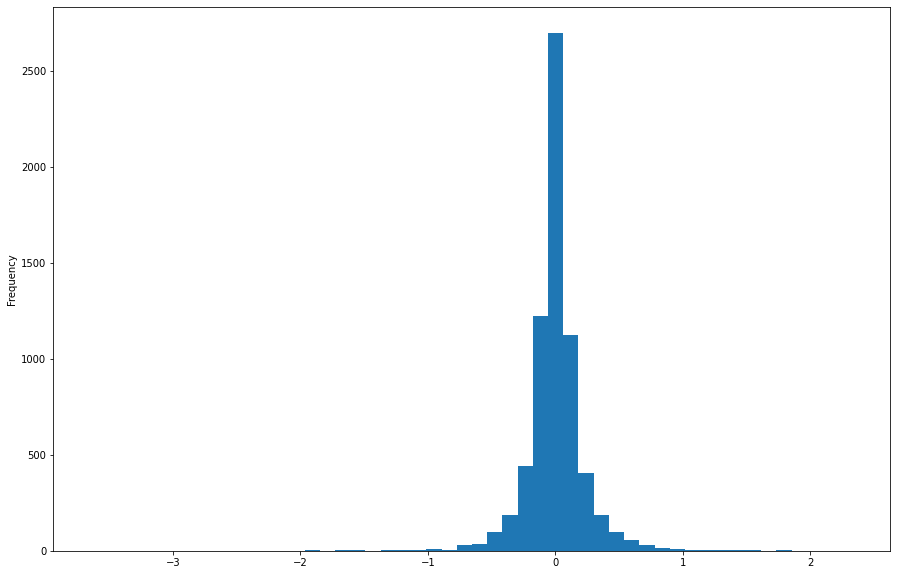

In [99]:
close_diff.plot(kind='hist', bins=50, figsize=(15, 10));

In [100]:
# set NaNs equal to 0
close_diff[close_diff.isna()] = 0

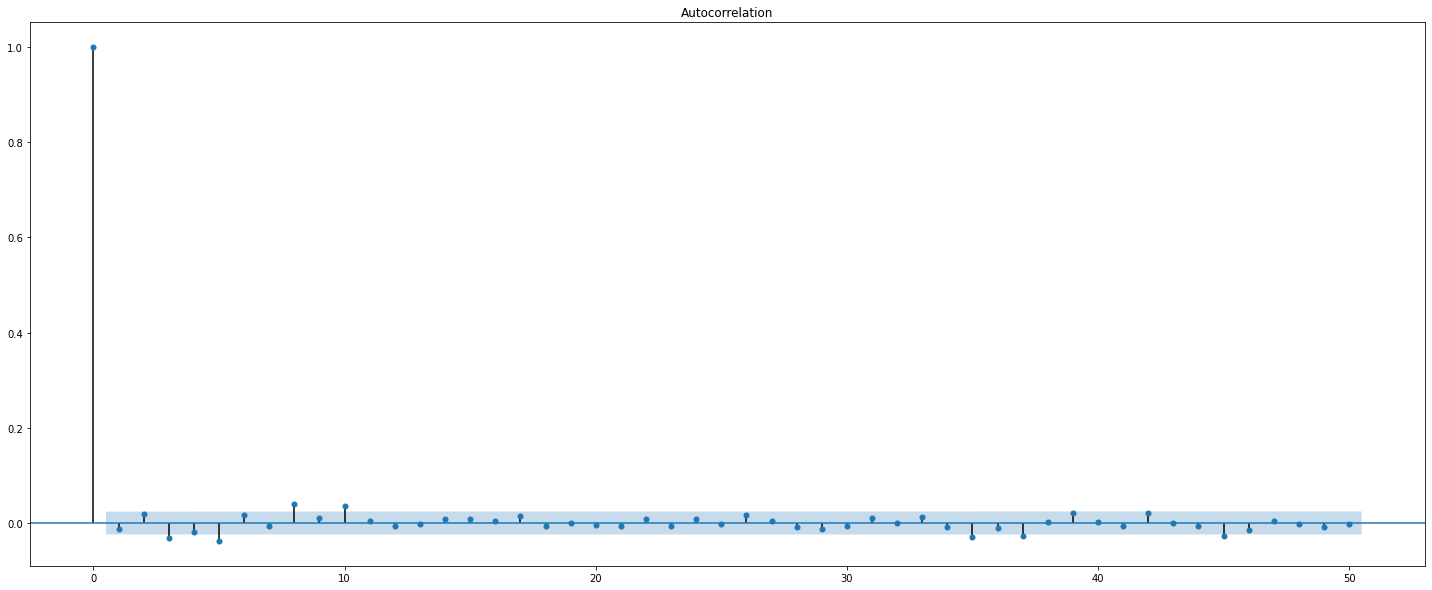

In [101]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_acf(close_diff, lags=50, ax=ax);

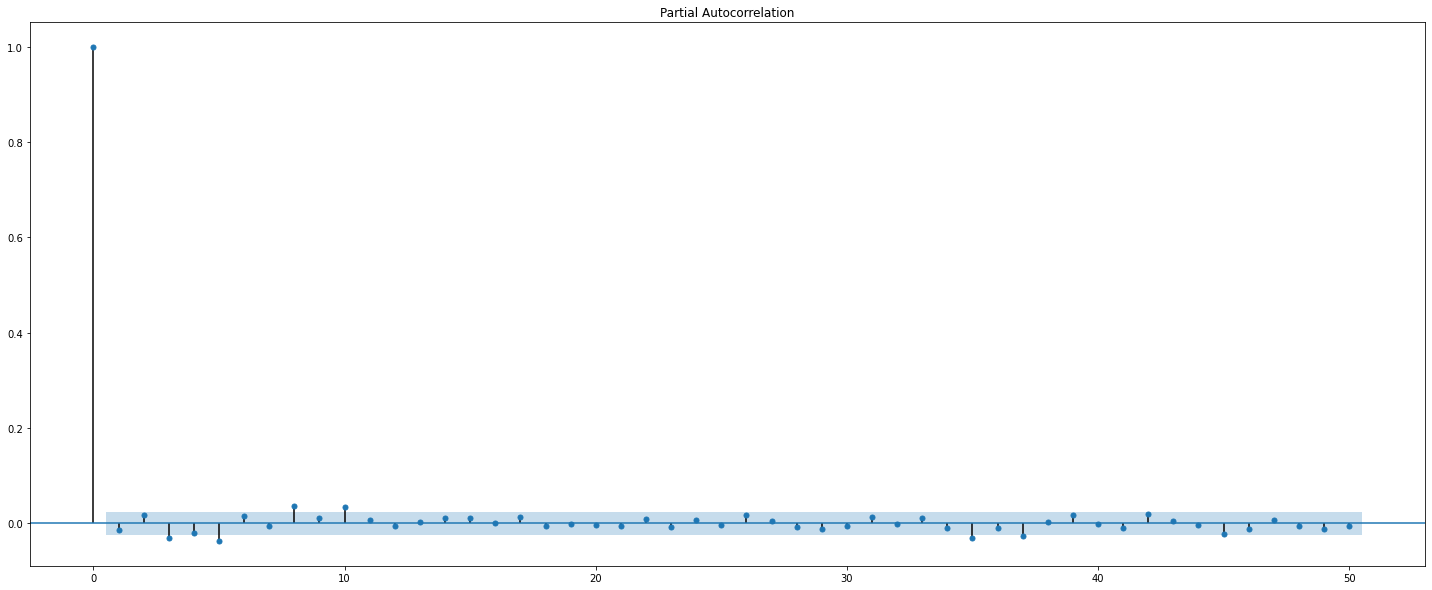

In [102]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_pacf(close_diff, lags=50, ax=ax);

## **Perform Time Series Clustering**

First we will need to identify where the major prices increases and decrease occur.

In [103]:
price_increase_locs = np.where(close_diff > 0.5)[0]
price_decrease_locs = np.where(close_diff < -0.5)[0]

Now let's get each chop price increase into it's own Time Series of $n$ values. Then we can try to cluster these Time Series and see if there are any consistencies in the data leading up to the price increase. Note that some of the price increases happen on near simultaneous days, especially if there is a large run up. We will need to figure out how to account for this. We will also cluster the Time Series Leading up to price decreases to see if there are any major differences.

Now let's cluster the chopped Time Series. We will use [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) to perform K-means clustering on the Time Series. We will also Standardize the Time Series to have 0 mean and a Standard Deviation of 1. We will choose not to detrend or de seasonalize the chopped Time Series, since we want the clusters to capture this information.

In [ ]:
!pip install tslearn

In [154]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

n = 16 # number of value per time series (4hr intervals)
price_increase_locs = price_increase_locs[price_increase_locs > n]
price_decrease_locs = price_decrease_locs[price_decrease_locs > n]

# standardize the closing prices
# sc = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit(df['close'].to_numpy()[:, None])
# close_stand = sc.transform(df['close'].to_numpy()[:, None]).squeeze()

# manually standardize
c_mu = df['close'].to_numpy().mean()
c_std = df['close'].to_numpy().std()

close_stand = (df['close'].to_numpy()[:, None] - c_mu) / c_std


# get chopped Time Series for price increases
ts_up_list = []
for loc in price_increase_locs:
    ts_vals = close_stand[loc-n:loc+1]
    ts_up_list.append(ts_vals)

# get chopped Time Series for price decreases
ts_down_list = []
for loc in price_decrease_locs:
    ts_vals = close_stand[loc-n:loc+1]
    ts_down_list.append(ts_vals)

In [155]:
ts_up_array = np.array(ts_up_list)
ts_down_array = np.array(ts_down_list)

In [156]:
from tslearn.clustering import TimeSeriesKMeans

ts_kmeans_up = TimeSeriesKMeans(n_clusters=4, metric="softdtw",
                                max_iter=10, random_state=42)
ts_kmeans_down = TimeSeriesKMeans(n_clusters=4, metric="softdtw",
                                max_iter=10, random_state=42)

# possibly incorrect method
# ts_up_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
#                                                        std=1.).fit_transform(ts_up_array) \
#                                                               .squeeze()
# ts_down_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
#                                                        std=1.).fit_transform(ts_down_array) \
#                                                               .squeeze()  

# manually standardize selected price movement time series with original scalers
ts_up_array_transformed = (ts_up_array - c_mu)/c_std
ts_down_array_transformed = (ts_down_array- c_mu)/c_std                                                                                                                                                                                   

In [157]:
ts_up_cluster_locs = ts_kmeans_up.fit_predict(ts_up_array_transformed)

In [158]:
ts_down_cluster_locs = ts_kmeans_down.fit_predict(ts_down_array_transformed)

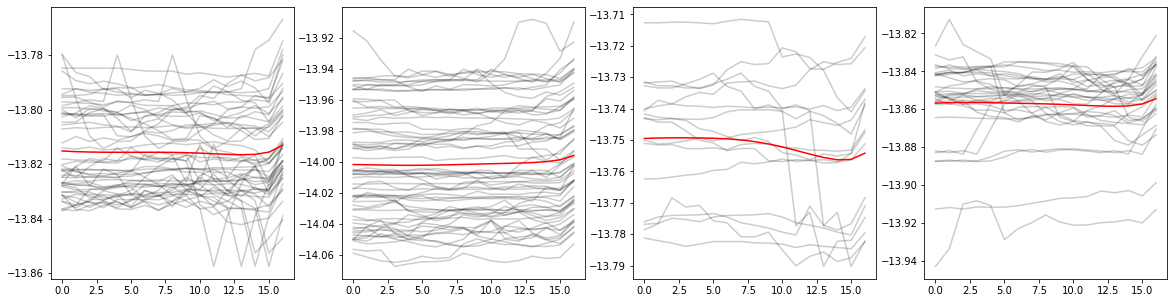

In [159]:
# display price increase clusters
fig = plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    for ts_vals in ts_up_array_transformed[ts_up_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_up.cluster_centers_[i].ravel(), 'r-')

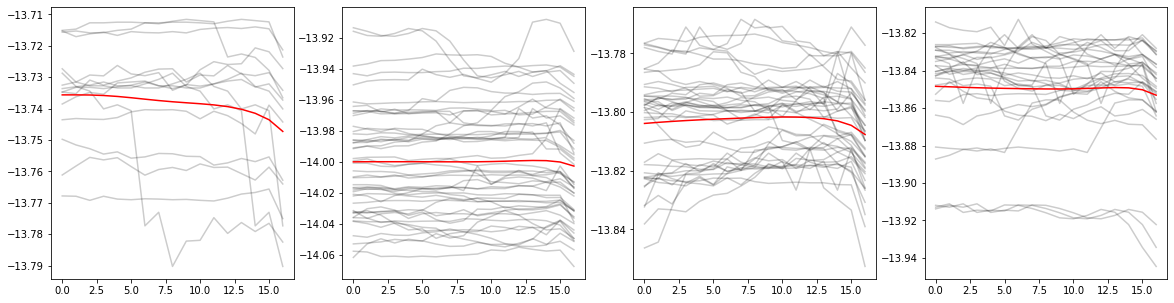

In [160]:
# display price decrease clusters
fig = plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    for ts_vals in ts_down_array_transformed[ts_down_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_down.cluster_centers_[i].ravel(), 'r-')

There doesn't seem to be anything special about the clusters obtained from this analysis of daily data. It's possible that more meaningful clusters can be found when observing the data through a different time scale such as an hourly interval or 15minute interval.

In [ ]:
!pip install stumpy

In [162]:
import stumpy

m = 16
mp = stumpy.stump(df['close'].sort_index(), m=m)

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


From stumpy [github](https://github.com/TDAmeritrade/stumpy/blob/main/stumpy/stump.py):

```
out : numpy.ndarray
        The first column consists of the matrix profile, the second column
        consists of the matrix profile indices, the third column consists of
        the left matrix profile indices, and the fourth column consists of
        the right matrix profile indices.
```
      

In [163]:
motif_idx = np.argsort(mp[:, 0])[0]
nearest_neighbor_idx = mp[motif_idx, 1]

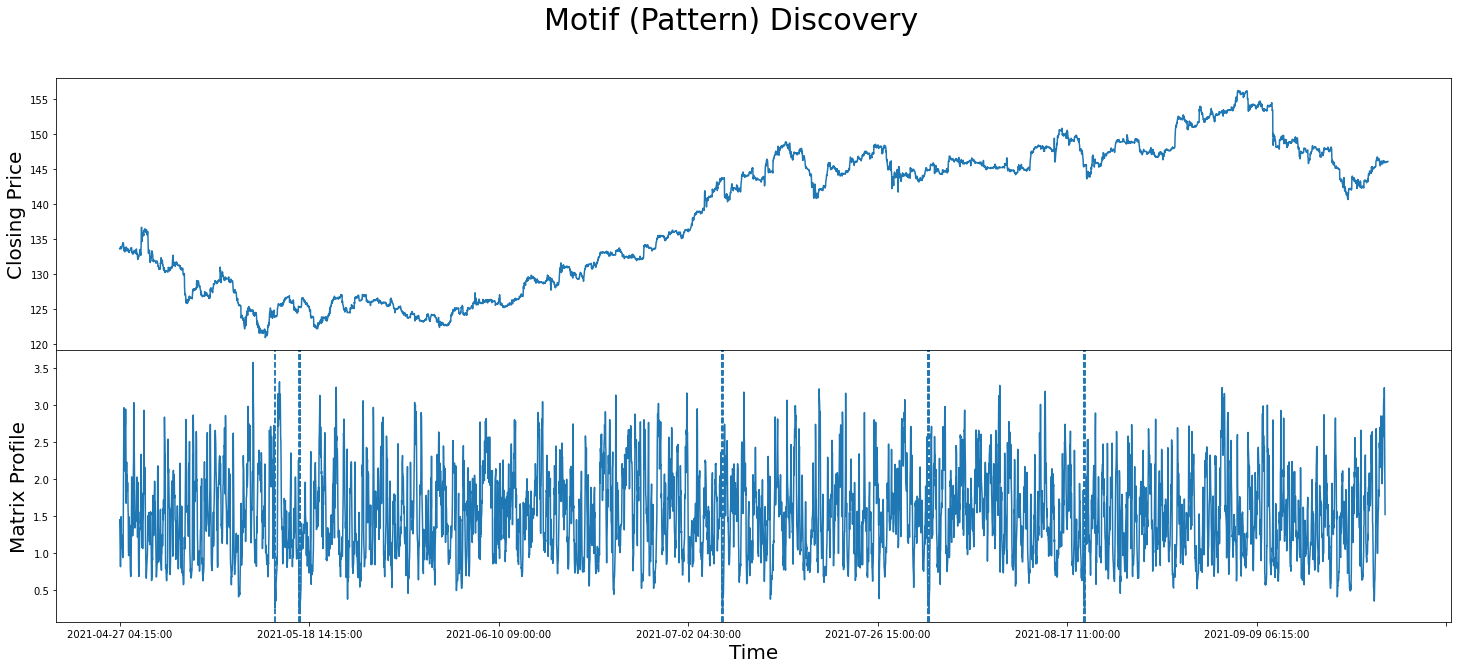

In [164]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(25, 10))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

# plot closing price
df['close'].sort_index().plot(ax=axs[0])
axs[0].set_ylabel('Closing Price', fontsize='20')

# plot Matrix Profile
axs[1].plot(mp[:, 0])

# indicate Motif locaitons
for i in range(15):
    # get motifs
    motif_idx = np.argsort(mp[:, 0])[i]
    nearest_neighbor_idx = mp[motif_idx, 1]

    rect = Rectangle((motif_idx, 0), m, 100, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 100, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")

plt.show()

## Plot top 25 motifs

First filter out motifs that are close together in time. Since motifs that are within 5-10 lags will have very similar patterns, but are not useful for our analysis.

In [172]:
mp.shape

(6677, 4)

In [278]:
# get motifs to plots

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []
useful_motif_indexes = []

# threshold for similar motifs spacd in time 
thresh = 15

i = 0
while i < mp.shape[0] // 26:
    # get motifs
    motif_idx = np.argsort(mp[:, 0])[i]
    nearest_neighbor_idx = mp[motif_idx, 1]

    if i == 0:
        useful_motif_indexes.append(motif_idx)

        # store motif index
        motif_indexes.append(motif_idx)

        # increment i
        i += 1

        continue
    
    if (np.min(np.abs(motif_idx - np.array(motif_indexes))) > thresh):
        useful_motif_indexes.append(motif_idx)

    # store motif index
    motif_indexes.append(motif_idx)
    
    # increment i
    i += 1

In [279]:
len(useful_motif_indexes)

58

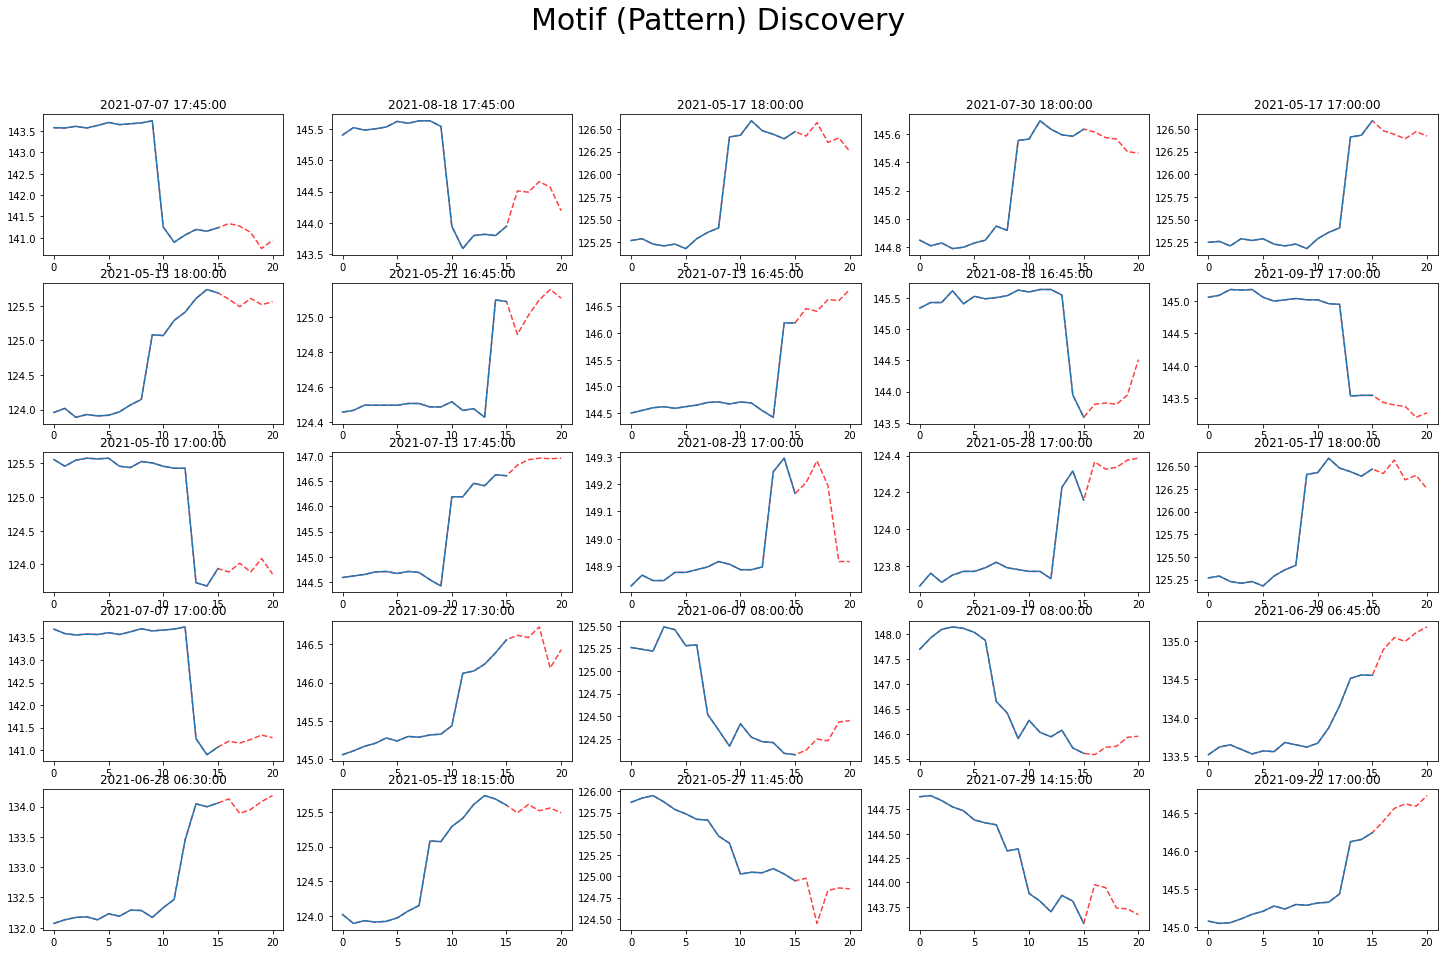

In [185]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []

# threshold for similar motifs spacd in time 
thresh = 15

fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif_idx = useful_motif_indexes[i]
    nearest_neighbor_idx = mp[motif_idx, 1]


    # plot motif index
    motif = df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m]
    motif_ext = df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m + 5]

    plt.plot(motif_ext.to_numpy(), 'r--', alpha=0.75)
    plt.plot(motif.to_numpy())
    
    plt.title(df['close'].index[nearest_neighbor_idx])


From the Matrix Profiling, the Blue indicates the matched Motifs and the Red is the next 10 days after the matched motif. There appear to be similar patterns in the discovered motifs, now let's cluster them and see what the dominant patterns are!

In [280]:
useful_motifs = []
for motif_idx in useful_motif_indexes:
    nearest_neighbor_idx = mp[motif_idx, 1]
    motif = df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m]
    useful_motifs.append(motif.to_numpy())

In [281]:
useful_motifs = np.array(useful_motifs)

In [282]:
# manually standardize motifs with original scalers
useful_motifs_stand = (useful_motifs - c_mu)/c_std

In [283]:
# get kmeans clustering object
motif_kmeans = TimeSeriesKMeans(n_clusters=4, metric="softdtw",
                                max_iter=10, random_state=42)

In [284]:
motif_cluster_locs = motif_kmeans.fit_predict(useful_motifs_stand[:, :, None])

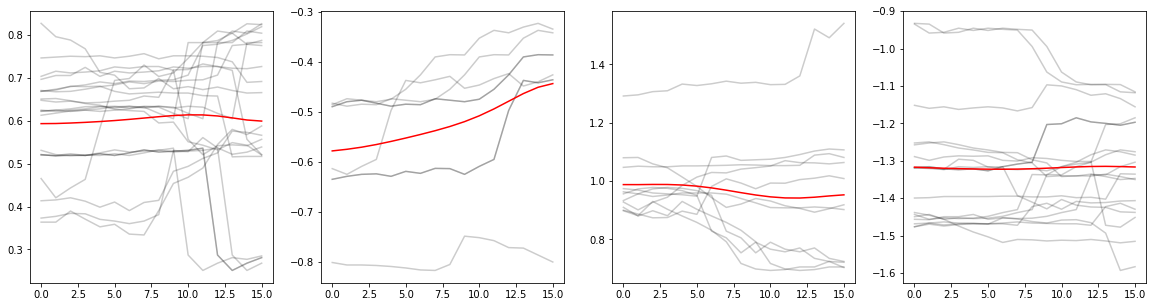

In [285]:
# display motif clusters
# display price increase clusters
fig = plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    for motif in useful_motifs_stand[motif_cluster_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)

    plt.plot(motif_kmeans.cluster_centers_[i].ravel(), 'r-')

In [286]:
motif_cluster_locs

array([0, 0, 3, 0, 3, 3, 3, 0, 0, 0, 3, 0, 2, 3, 3, 0, 0, 3, 2, 1, 1, 3,
       3, 0, 0, 2, 0, 3, 0, 3, 2, 2, 0, 3, 0, 1, 1, 0, 0, 1, 2, 0, 2, 2,
       1, 3, 1, 2, 1, 0, 3, 0, 3, 2, 3, 2, 3, 0])

## **Perform Fourier Analysis**

In [ ]:
# set NaNs equal to 0
close_diff[close_diff.isna()] = 0

In [ ]:
sp = np.fft.fft(close_diff)
theta = np.arctan(sp.imag/sp.real)
numValues = len(close_diff)
numValuesHalf = numValues/2

amp = np.abs(sp)/np.sqrt(numValues)
freq = np.fft.fftfreq(sp.size, d=1)

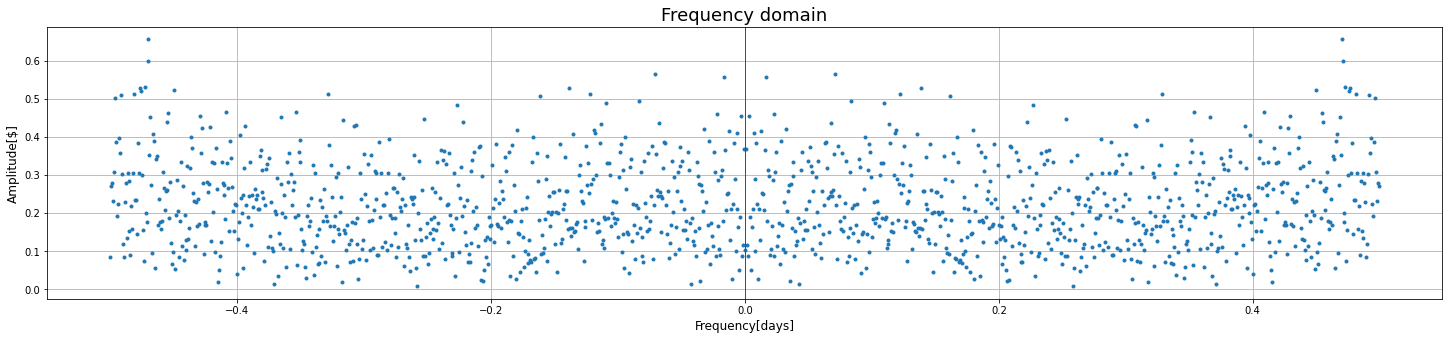

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(freq, amp ,'.')
plt.axvline(x=0, ymin=0, ymax=1, linewidth=1, color='r')

plt.ylabel('Amplitude[$]', fontsize=12)
plt.xlabel('Frequency[days]', fontsize=12)
plt.title('Frequency domain', fontsize=18)
plt.grid()

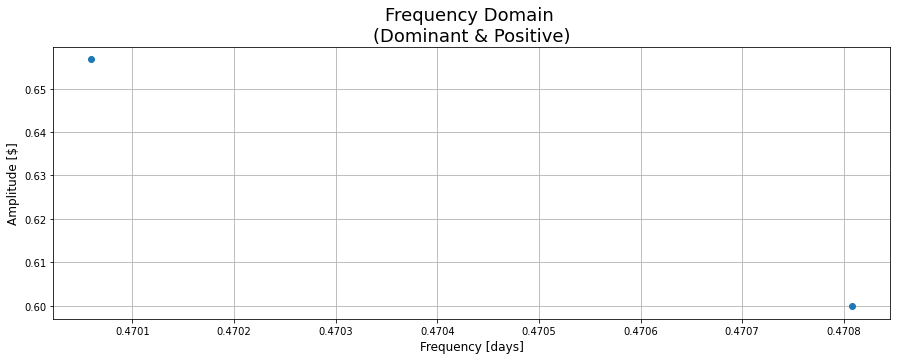

In [ ]:
meanAmp = amp.mean()
stdAmp = amp.std()
dominantAmpCheck = amp > (3*stdAmp + meanAmp) 
positiveFreqCheck = freq > 0
dominantAmp = amp[dominantAmpCheck & positiveFreqCheck]
dominantFreq = freq[dominantAmpCheck & positiveFreqCheck]
dominantTheta = theta[dominantAmpCheck & positiveFreqCheck]

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid()

In [ ]:
dominantAmp, dominantFreq

(array([0.65676372, 0.59978314]), array([0.47005988, 0.47080838]))

## **Perform Wavelet Analysis**